Name: Patrick Ng  
Class: W261-2  
Date: Mar 19, 2016  
HW09

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## HW 9.0: Short answer questions

What is PageRank and what is it used for in the context of web search?  
What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to 
compute the steady state distibuton?  


#### What is PageRank and what is it used for in the context of web search?  
PageRank is a link analysis algorithm and it assigns a numerical weighting to each element of a hyperlinked set of documents, such as the World Wide Web, with the purpose of "measuring" its relative importance within the set.  In the context of web search, it is used for ranking the documents in the posting list of the inverted index, so that relatively more important documents will be put at the beginning of the posting list.  
  
#### What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to compute the steady state distibuton?  
In order to leverage the machinery of Markov Chains to compute the steady state distibuton, we need to make two adjustments to the webgraph (i.e. the transition matrix H, where each row represents a node):
+ **Stochasticity adjustment** to resolve dangling nodes (nodes with no outbound links) problem:
    + For each zero row we replace each element with 1/n, where n is the number of nodes in the wegraph.
+ **Primitivity adjustment** to guarantee convergence.
    + We need to define a teleport probability $\alpha$ and define the transition matrix as:  
<br/>
\begin{equation} 
P = (1-\alpha)H + {\alpha}I(1/n)  
\end{equation}  
where:  
        - _H_ is the hyperlink matrix
        - n is the number of nodes in the webgraph
        - I is the identity matrix
        
#### OPTIONAL: In topic-specific pagerank, how can we insure that the irreducible property is satified? (HINT: see HW9.4)  
The topic-specific pagerank paper ensures irreducibility by requiring that nodes not reachable from in-topic nodes be removed from the network. 


## HW 9.1: MRJob implementation of basic PageRank

Write a basic MRJob implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input (as explored in HW 7).
Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), 
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).  

NOTE: 
+ The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability d,
one of the hyperlinks in the current page. This probability is represented by a so-called
‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and “teleports” to that page]


As you build your code, use the test data

s3://ucb-mids-mls-networks/PageRank-test.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name.  
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck
your work with the true result, displayed in the first image
in the Wikipedia article:

https://en.wikipedia.org/wiki/PageRank

and here for reference are the corresponding PageRank probabilities:
```
A,0.033
B,0.384
C,0.343
D,0.039
E,0.081
F,0.039
G,0.016
H,0.016
I,0.016
J,0.016
K,0.016
```

### Initialize the graph structure based on the adjaceny list file

In [48]:
%%writefile MrInitGraph.py
import re
from mrjob.job import MRJob, MRStep
import mrjob
import json
import sys

class MrInitGraph(MRJob):

    SORT_VALUES = True  # Need 2nd sort
   
    def mapper(self, _, line):
        # input format:
        # Json object:
        # 1       {'2': 1, '6': 1}
        
        fields = line.strip().split('\t')
        node = fields[0]

        # JSON uses double quote for string
        adjList = json.loads(fields[1].replace("'", '"'))
        
        # Output for the node, which is an outbound node
        yield node, [0, adjList.keys()] # 0 is used for 2nd sorting
        
        # Also need to output an empty entry for every nodes in the adjList.
        # It is needed for directed graph, so that in the reducer we can generate 
        # an entry for nodes which don't have an outbound link.
        for key in adjList.keys():
            yield key, [1]  # 1 is used for 2nd sorting
            
    def reducer(self, node, values):
        value = values.next()
        
        # An outbound node will be seen first because we use 2nd sorting
        if value[0] == 0:
            # It's an outbound record.  
            # Just yield the node without processing the rest of values.
            yield node, [value[1], 0]
        else:
            # In a directed graph, if a node has no outbound link, generate an entry for it.
            # And ignore the rest of values
            yield node, [[], 0]
                                                              
if __name__ == '__main__':
    MrInitGraph.run()

Overwriting MrInitGraph.py


### Calculate the number of nodes

In [46]:
%%writefile MrFindNumberOfNodes.py
import re
from mrjob.job import MRJob, MRStep
import mrjob
import json
import sys

class MrFindNumberOfNodes(MRJob):
    
    def steps(self):
        return [MRStep(mapper_init=self.mapper_init, mapper=self.mapper, mapper_final = self.mapper_final,
                   combiner = self.reducer,
                   reducer=self.reducer
            )]

    def mapper_init(self):
        self.partial_size = 0
        
    def mapper(self, _, line):
        self.partial_size += 1
        
    def mapper_final(self):
        yield None, self.partial_size
        
    def reducer(self, key, values):
        yield None, sum(values)
                                                              
if __name__ == '__main__':
    MrFindNumberOfNodes.run()

Overwriting MrFindNumberOfNodes.py


### A PageRank iteration - Job 01 and Job 02

#### Job 01 - Each node distributes its PageRank evenly to all its neighbors

In [80]:
%%writefile MrPageRankJob01.py
from __future__ import division
import re
from mrjob.job import MRJob, MRStep
import mrjob
import json
import sys

class MrPageRankJob01(MRJob):

    INPUT_PROTOCOL = mrjob.protocol.JSONProtocol
    
    Type_Graph = 0
    Type_PR = 1
    
    Key_LostPR = "#"
    
    def configure_options(self):
        super(MrPageRankJob01, self).configure_options()
        self.add_passthrough_option(
            '--initWithGraphSize', type='int', default=None)

    def mapper_init(self):
        self.lostPR = 0
        
    def mapper(self, node, data):
        adjList, pageRank = data
        
        # We're at the first iteration, and PageRank value hasn't been initialized yet.
        if self.options.initWithGraphSize is not None:
            pageRank = 1 / self.options.initWithGraphSize

        # Pass along the graph structure
        yield node, [self.Type_Graph, adjList]
        
        if len(adjList) > 0:
            # The PR juice we will send out
            p = pageRank / len(adjList)
            for link in adjList:
                yield link, [self.Type_PR, p] # 1 means it's a PR contribution
        else:
            self.lostPR += pageRank
            
    def mapper_final(self):
        yield self.Key_LostPR, self.lostPR

    def reducer(self, node, values):
        pageRank = 0
        if node == self.Key_LostPR:
            yield self.Key_LostPR, sum(values)
        else:
            for value in values:
                valueType, data = value
                if valueType == self.Type_Graph:
                    adjList = data
                else:
                    pageRank += float(data)

            yield node, [adjList, pageRank]
            
                                                              
if __name__ == '__main__':
    MrPageRankJob01.run()

Overwriting MrPageRankJob01.py


#### Job 02 - Update each node's PageRank usng the "lost PR" (aka missing mass) from last job, and also the teleport vector.

In [107]:
%%writefile MrPageRankJob02.py
from __future__ import division
import re
from mrjob.job import MRJob, MRStep
import mrjob
import json
import sys

class MrPageRankJob02(MRJob):

    INPUT_PROTOCOL = mrjob.protocol.JSONProtocol
    
    Key_LostPR = "#"
    
    def configure_options(self):
        super(MrPageRankJob02, self).configure_options()
        self.add_passthrough_option('--graphSize', type=int, default=None)
        self.add_passthrough_option('--lostPR', type=float, default=None)
        self.add_passthrough_option('--teleportRate', type=float, default=None) 
        self.add_passthrough_option('--dampingVectorFile', type=str, default=None) 
        
    def mapper_init(self):
        # For HW9.4 - Topic-sensitive PageRank
        self.dampingVector = None
        
        if self.options.dampingVectorFile is not None:
            with open(self.options.dampingVectorFile, 'r') as f:
                self.dampingVector = json.load(f)

    def mapper(self, node, data):
        if node == self.Key_LostPR:
            return
        
        adjList, pageRank = data
        
        # For HW9.4 - Topic-sensitive PageRank
        if self.dampingVector is None:
            p = 1 / self.options.graphSize
        else:
            p = self.dampingVector[str(node)] # Integer key in JSON dict are still loaded as string

        pageRank = self.options.teleportRate * p + \
                   (1-self.options.teleportRate) * (self.options.lostPR / self.options.graphSize + pageRank)

        # Pass along the graph structure
        yield node, [adjList, pageRank]                        
                                                              
if __name__ == '__main__':
    MrPageRankJob02.run()

Overwriting MrPageRankJob02.py


#### Sort result according to PageRank

In [33]:
%%writefile MrSortPageRank.py
from __future__ import division
import re
from mrjob.job import MRJob, MRStep
import mrjob
import json
import sys

def toStringKey(n):
    n = int(n)
    digits = len(str(sys.maxint))
    minInt = -sys.maxint - 1

    if n < 0:
        key = "-" + str(abs(minInt-n)).zfill(digits)
    else:
        key = str(n).zfill(digits)

    return key

class MrSortPageRank(MRJob):

    INPUT_PROTOCOL = mrjob.protocol.JSONProtocol
    
    def configure_options(self):
        super(MrSortPageRank, self).configure_options()
        self.add_passthrough_option('--count', type=int, default=100)
        
    def mapper(self, node, data):
        adjList, pageRank = data
        # Want to sort in descending order.  So use (1-pageRank)
        yield toStringKey((1-pageRank) * 1000000000), [node, pageRank]
        
    def reducer_init(self):
        self.emitted = 0
            
    def reducer(self, _, values):
        
        for value in values:
            if self.emitted == self.options.count:
                return
            
            self.emitted += 1
            yield value[0], value[1]
        
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                   reducer=self.reducer,
                   reducer_init = self.reducer_init,
                    jobconf={
                    "mapred.reduce.tasks" : "1"}
                  )
        ]
    
if __name__ == '__main__':
    MrSortPageRank.run()

Overwriting MrSortPageRank.py


### Driver for HW91

In [113]:
%%writefile Driver_Hw91.py
from __future__ import division
from MrFindNumberOfNodes import MrFindNumberOfNodes
from MrInitGraph import MrInitGraph
from MrPageRankJob01 import MrPageRankJob01
from MrPageRankJob02 import MrPageRankJob02
from MrSortPageRank import MrSortPageRank
import time
import boto
from boto.s3.key import Key
import mrjob.parse

import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--inputFile", type=str)
parser.add_argument("--jobPrefix", type=str, default="", help="Prefix string added to the front of any locally written file")
parser.add_argument("--initGraphPath", type=str, default="initGraph.txt")
parser.add_argument("--graphSizePath", type=str, default="graphSize.txt")
parser.add_argument("--initGraphAndSizeOnly", action="store_true", help="Only run init Graph and Size")
parser.add_argument("--outputPath", type=str, default=None)
parser.add_argument("--num-ec2-instances", type=str, default=None)
parser.add_argument("--ec2-instance-type", type=str, default=None)
parser.add_argument("--teleportRate", type=float, default=0.15)
parser.add_argument("--ec2-core-instance-bid-price", type=float, default=0)
parser.add_argument("--skipInitGraphAndSize", action="store_true", help="Don't run initGraph and getGraphSize")
parser.add_argument("--printResult", action="store_true")
parser.add_argument("--nodeCount", type=int, help="Specify nodeCount; for debug purpose")
parser.add_argument("--iteration", type=int, default=5)
parser.add_argument("--resultCount", type=int, default=20, help="Size of sorted result")
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--resultFile", type=str, default=None, help="Name of the pageRank result file")
parser.add_argument("--outputPath02", type=str, default=None, help="For debug only")
parser.add_argument("--dampingVectorFile", type=str, default=None, help="Path to the JSON damping vector file.  For HW9.4.")
parser.add_argument("-r", "--run", type=str)
args = parser.parse_args()

jobArgsBase = ['-r', args.run,
             '--no-strict-protocols']

if args.quiet:
    jobArgsBase += ['-q']

if args.run == "emr":
    jobArgsBase += ["--pool-emr-job-flows",
                   "--ec2-core-instance-bid-price", str(args.ec2_core_instance_bid_price)]
    
    if args.ec2_instance_type is not None:
        jobArgsBase += ["--ec2-instance-type", args.ec2_instance_type]
        
    if args.num_ec2_instances is not None:
        jobArgsBase += ["--num-ec2-instances", args.num_ec2_instances]

i = 1
startTime = time.time()

initGraphPath = None
nodeCount = None
outputPath02 = None

def ensureFolderPath(path):
    return path if path.endswith("/") else path + "/"

def printMilestone(s):
    if not args.quiet:
        print s + "  (%.2fs from start)" % (time.time() - startTime)
    
def initGraphStructure():
    global initGraphPath
    
    printMilestone("Init Graph Structure")
    
    # Initialize the graph structure
    jobArgs = [args.inputFile] + jobArgsBase

    if args.run == "inline" or args.run == "local":
        initGraphPath = args.jobPrefix + args.initGraphPath
        writeOutput = True
    else:
        initGraphPath = ensureFolderPath(args.initGraphPath)
        jobArgs += ["--no-output", "--output-dir", initGraphPath]
        writeOutput = False

    if args.skipInitGraphAndSize:
        printMilestone("Skip MrInitGraph because we're asked to")
    else:
        mr_jobInitGraph = MrInitGraph(args=jobArgs)
        with mr_jobInitGraph.make_runner() as runner: 
            runner.run()

            if writeOutput:
                # Generate the initGraph file
                with open(initGraphPath, 'w') as f:            
                    for line in runner.stream_output():
                        f.write("%s" % (line))
    

def findGraphSize():
    global nodeCount
    
    printMilestone("Find Graph Size")
    graphSizePath = args.jobPrefix + args.graphSizePath
    
    if args.skipInitGraphAndSize:
        if args.nodeCount is not None:
            # nodeCount already provided.  For debug purpose.
            nodeCount = args.nodeCount
            printMilestone("Skip MrFindNumberOfNodes because nodeCount is provided")
        else:
            printMilestone("Read graph size from file " + graphSizePath)
            with open(graphSizePath, 'r') as f:            
                nodeCount = int(f.read().strip())            
    else:
        # Find the number of nodes
        mr_jobNumberOfNodes = MrFindNumberOfNodes(args=[initGraphPath] + jobArgsBase)
        with mr_jobNumberOfNodes.make_runner() as runner: 
            runner.run()

            for line in runner.stream_output():
                key, value =  mr_jobNumberOfNodes.parse_output_line(line)
                nodeCount = int(value)

        with open(graphSizePath, 'w') as f:            
            f.write(str(nodeCount))
            
    printMilestone("Number of nodes = %d" % (nodeCount))


def readLostPRFromS3(outputPath):
    # Read the lost PR from one of the output file.  We will read the beginning portion of each file
    # and see if we can find that special lost PR key.

    s3_connection = boto.connect_s3()

    # Example of outputPath: s3://patng323-w261-hw91/output/
    assert mrjob.parse.is_s3_uri(outputPath)
    bucket, key = mrjob.parse.parse_s3_uri(outputPath)
    bucket = s3_connection.get_bucket(bucket)
    pattern = key + 'part-'

    for key in s3_connection.get_bucket(bucket):
        #print 'key.name=', key.name

        # ignore the file we don't care
        if not key.name.startswith(pattern):
            continue

        content = key.get_contents_as_string(headers={'Range' : 'bytes=0-100'})
        content = content.partition("\n")[0] # Get the first line

        fields = content.split('\t')
        if fields[0] == '"' + MrPageRankJob01.Key_LostPR + '"':
            assert len(fields) == 2
            lostPR = float(fields[1])
            return lostPR
    
    assert False, "lostPR isn't found"

def runPageRank(iterations):
    global outputPath02
    graphInited = False

    for i in range(1, iterations+1):
        # Run MrPageRankJob01
        printMilestone("Iteration %02d-1" % i)

        if i == 1:
            inputPath = initGraphPath
        else:
            inputPath = outputPath02 # from job02 in last iteration

        jobArgs = [inputPath] + jobArgsBase
        if args.run == "inline" or args.run == "local":
            outputPath01 = args.jobPrefix + "output-%02d-1.txt" % i
            writeOutput = True
        else:
            outputPath01 = ensureFolderPath(args.outputPath) + "iter" + str(i) + "-1/"
            writeOutput = False

            jobArgs += ["--output-dir", outputPath01] 

            # For this HW we'll use stream-output for Hadoop
            if args.run == "emr":
                jobArgs += ["--no-output"]

        if not graphInited:
            jobArgs += ["--initWithGraphSize", str(nodeCount)]
            graphInited = True

        # Run Job 01 - each node distribute its PageRank to all its neighbors
        mr_jobPageRankJob01 = MrPageRankJob01(args=jobArgs)
        with mr_jobPageRankJob01.make_runner() as runner: 
            runner.run()

            if args.run == "inline" or args.run == "local" or args.run == "hadoop":
                if writeOutput:
                    f = open(outputPath01, 'w')

                for line in runner.stream_output():
                    key, value =  mr_jobPageRankJob01.parse_output_line(line)
                    if key == MrPageRankJob01.Key_LostPR:
                        lostPR = float(value)
                    else:
                        if writeOutput:
                            f.write(line)
                            
                        #if args.printResult:
                        #    print line.strip()


                if writeOutput:
                    f.close()

            else:
                time.sleep(5) # Sleep a bit for S3 consistency
                lostPR = readLostPRFromS3(outputPath01)


        # Run Job 02 - Distribute the lost PR and also the teleported PageRank
        jobArgs = [outputPath01] + jobArgsBase

        if args.run == "inline" or args.run == "local":
            outputPath02 = args.jobPrefix + "output-%02d-2.txt" % i
            
            # For HW9.4 - Topic-sensitive PageRank
            if args.dampingVectorFile is not None:
                jobArgs += ["--file", args.dampingVectorFile]
                jobArgs += ["--dampingVectorFile", args.dampingVectorFile]
                
            writeOutput = True
        else:
            outputPath02 = ensureFolderPath(args.outputPath) + "iter" + str(i) + "-2/"
            writeOutput = False

            jobArgs += ["--output-dir", outputPath02] 

            # For this HW we'll use stream-output for Hadoop
            if args.run == "emr":
                jobArgs += ["--no-output"]

        jobArgs += ['--graphSize', str(nodeCount), '--lostPR', str(lostPR), 
                    '--teleportRate', str(args.teleportRate)]

        printMilestone("Iteration %02d-2" % i)
        mr_jobPageRankJob02 = MrPageRankJob02(args=jobArgs)
        with mr_jobPageRankJob02.make_runner() as runner: 
            totalPR = 0
            runner.run()
            if args.run == "inline" or args.run == "local" or args.run == "hadoop":
                if writeOutput:
                    f = open(outputPath02, 'w')

                for line in runner.stream_output():
                    if writeOutput:
                        f.write(line)

                    key, value =  mr_jobPageRankJob01.parse_output_line(line)
                    totalPR += float(value[1])

                    if args.printResult:
                        print line.strip()

                if writeOutput:
                    f.close()

        if args.printResult:
            print

def outputSortedResult(resultCount, resultPath):

    # Run MrPageRankJob01
    printMilestone("Output Sorted Result:")

    jobArgs = [resultPath, "--count", str(resultCount)] + jobArgsBase

    # Run Job 01 - each node distribute its PageRank to all its neighbors
    mr_job = MrSortPageRank(args=jobArgs)
    
    resultFile = args.resultFile
    if args.resultFile is None:
        resultFile = args.jobPrefix + "result-%s.txt" % args.run
        
    with mr_job.make_runner() as runner: 
        runner.run()

        with open(resultFile, "w") as f:
            for line in runner.stream_output():
                f.write(line)
                
    return resultFile

# The flow
initGraphStructure()
findGraphSize()

if not args.initGraphAndSizeOnly:
    runPageRank(args.iteration)
    fn = outputSortedResult(args.resultCount, outputPath02)
    printMilestone("Done")

if not args.quiet:
    print
    if args.initGraphAndSizeOnly:
        print "Done initializing graph and get size."
    else:
        print "Total result location:", outputPath02
        print "Sorted result location:", fn
    print
    print "Total time: %.3fs" % (time.time() - startTime)

Overwriting Driver_Hw91.py


In [85]:
!rm -f output.txt
!rm -f initGraph.txt

!python Driver_Hw91.py -r inline \
--inputFile PageRank-test.txt \
--iteration 32 \
--jobPrefix "hw91_" 


Init Graph Structure  (0.00s from start)
No handlers could be found for logger "mrjob.sim"
Find Graph Size  (0.06s from start)
Number of nodes = 11  (0.10s from start)
Iteration 01-1  (0.10s from start)
Iteration 01-2  (0.13s from start)
Iteration 02-1  (0.15s from start)
Iteration 02-2  (0.18s from start)
Iteration 03-1  (0.21s from start)
Iteration 03-2  (0.24s from start)
Iteration 04-1  (0.26s from start)
Iteration 04-2  (0.30s from start)
Iteration 05-1  (0.31s from start)
Iteration 05-2  (0.35s from start)
Iteration 06-1  (0.36s from start)
Iteration 06-2  (0.40s from start)
Iteration 07-1  (0.42s from start)
Iteration 07-2  (0.46s from start)
Iteration 08-1  (0.48s from start)
Iteration 08-2  (0.50s from start)
Iteration 09-1  (0.53s from start)
Iteration 09-2  (0.57s from start)
Iteration 10-1  (0.58s from start)
Iteration 10-2  (0.62s from start)
Iteration 11-1  (0.64s from start)
Iteration 11-2  (0.68s from start)
Iteration 12-1  (0.69s from start)
Iteration 12-2  (0.73s from

In [84]:
!cat hw91_result-inline.txt

"B"	0.383819961360017
"C"	0.343491271523257
"E"	0.08088569367474557
"D"	0.039087092382824914
"F"	0.039087092382824914
"A"	0.032781493405692794
"G"	0.016169479054123637
"H"	0.016169479054123637
"I"	0.016169479054123637
"J"	0.016169479054123637
"K"	0.016169479054123637


#### Test it on Hadoop

In [48]:
!hdfs dfs -rm -r hw91
!hdfs dfs -mkdir hw91

!python Driver_Hw91.py -r hadoop \
--inputFile PageRank-test.txt \
--initGraphPath hdfs://127.0.0.1/user/patrickng/hw91/init/ \
--outputPath hdfs://127.0.0.1/user/patrickng/hw91/output/ \
--iteration 3  

16/03/14 12:25:35 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted hw91
16/03/14 12:25:37 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Init Graph Structure  (0.00s from start)
No handlers could be found for logger "mrjob.compat"
Find Graph Size  (33.49s from start)
Number of nodes = 11  (73.35s from start)
Iteration 01-1  (73.35s from start)
Iteration: 01-2  (112.01s from start)
Iteration 02-1  (146.37s from start)
Iteration: 02-2  (186.57s from start)
Iteration 03-1  (220.53s from start)
Iteration: 03-2  (260.55s from start)
Output Sorted Result:  (298.19s from start)

Total result location: hdfs://127.0.0.1/user/patrickng/hw91/output/iter3-2/
Sorted result location: result-hadoop.txt

Total time: 341.967s


In [49]:
!cat result-hadoop.txt

"B"	0.40729180730104886
"C"	0.23815584801812972
"E"	0.11821894280902044
"A"	0.0640190695933832
"D"	0.0447357013030419
"F"	0.0447357013030419
"K"	0.016568585934478637
"J"	0.016568585934478637
"I"	0.016568585934478637
"H"	0.016568585934478637
"G"	0.016568585934478637


#### Test it on EMR

In [6]:
!aws s3 mb s3://patng323-w261-hw91
!aws s3 cp PageRank-test.txt s3://patng323-w261-hw91/input/
!aws s3 ls s3://patng323-w261-hw91/input/

make_bucket: s3://patng323-w261-hw91/
upload: ./PageRank-test.txt to s3://patng323-w261-hw91/input/PageRank-test.txt
2016-03-13 19:33:27        166 PageRank-test.txt


In [ ]:
!aws s3 rm --recursive --only-show-errors s3://patng323-w261-hw91/init
!aws s3 rm --recursive --only-show-errors s3://patng323-w261-hw91/output
!echo "Wait 5.0s sec for S3 eventual consistency"
!sleep 5

!python Driver_Hw91.py -r emr \
--inputFile PageRank-test.txt \
--initGraphPath s3://patng323-w261-hw91/init \
--outputPath s3://patng323-w261-hw91/output \
--num-ec2-instances 2 \
--ec2-instance-type m1.medium \
--iteration 3


In [8]:
!cat result-emr.txt

"B"	0.4072918073010488
"C"	0.23815584801812978
"E"	0.11821894280902044
"A"	0.064019069593383202
"D"	0.0447357013030419
"F"	0.0447357013030419
"G"	0.016568585934478637
"H"	0.016568585934478637
"I"	0.016568585934478637
"J"	0.016568585934478637
"K"	0.016568585934478637


## HW 9.2: Exploring PageRank teleportation and network plots
In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied.   

Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha,
so that each nodes radius is proportional to its PageRank score. In particular you should
do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1].  

Note your plots should look like the following:  
https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg

In [12]:
import json
import sys
import subprocess
import os

dampingFactors = [0,0.25,0.5,0.75, 0.85, 1]

for i, df in zip(range(len(dampingFactors)), dampingFactors):
    resultFile = "result-%s.txt" % str(i)
                 
    commands = "cd %s; " % os.getcwd()
    commands += "rm -f output.txt; "
    commands += "rm -f initGraph.txt; "
    commands += "rm -f %s; " % resultFile

    commands += ("python Driver_Hw91.py -r inline "
                 "--inputFile PageRank-test.txt "
                 "--iteration 30 "
                 "--teleportRate %f "
                 "--quiet "
                 "--resultFile %s" % (1-df, resultFile))
                 
    subprocess.check_call(commands, shell=True)

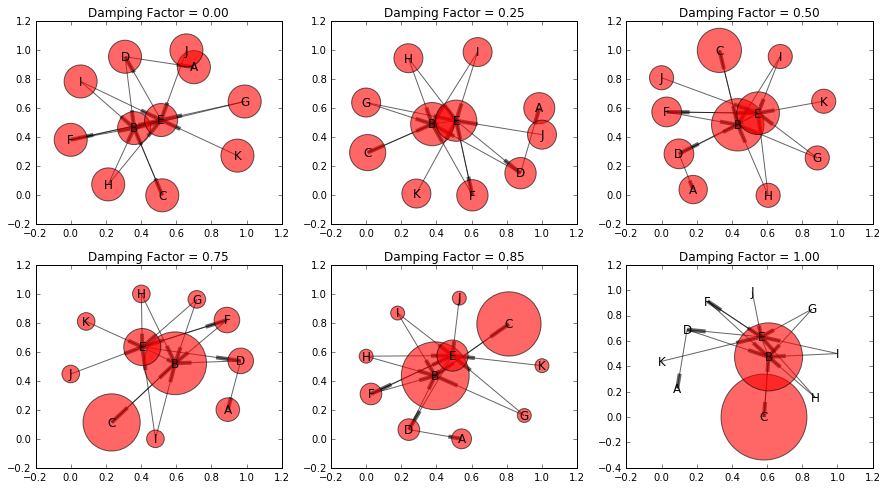

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.DiGraph()

with open("PageRank-test.txt", "r") as f:
    for line in f:
        fields = line.strip().split('\t')
        node = fields[0]
        adjList = json.loads(fields[1].replace("'", '"'))

        G.add_node(node)

        for k in adjList.keys():
            G.add_edge(node, k)

fig, axis_arr = plt.subplots(2,3,figsize=(15,8))

for i, df in zip(range(len(dampingFactors)), dampingFactors):
    resultFile = "result-%s.txt" % str(i)

    pageRanks = {}
    sizes = []

    with open(resultFile) as f:
        for line in f:
            fields = line.strip().split('\t')
            node = fields[0].replace('"', '')
            pageRanks[node] = float(fields[1])

    for n in G.nodes():
        sizes.append(pageRanks[n] * 300 * 40)

    ax = axis_arr.flatten()[i]
    ax.set_title('Damping Factor = %.2f' % df)
    nx.draw_networkx(G, with_labels=True, ax = ax, node_size = sizes, alpha=0.6)
    
plt.show()

## HW 9.3: Applying PageRank to the Wikipedia hyperlinks network

Run your PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).  

Run your PageRank implementation on the Wikipedia dataset for 50 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 


In [47]:
!aws s3 mb s3://patng323-w261-hw93

make_bucket: s3://patng323-w261-hw93/


In [ ]:
!aws s3 rm --recursive --only-show-errors s3://patng323-w261-hw93/init

In [52]:
!aws s3 rm --recursive --only-show-errors s3://patng323-w261-hw93/output-1
!echo "Wait 5.0s sec for S3 eventual consistency"
!sleep 5

!python Driver_Hw91.py -r emr \
--inputFile s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt  \
--initGraphPath s3://patng323-w261-hw93/init \
--outputPath s3://patng323-w261-hw93/output-1 \
--num-ec2-instances 4 \
--ec2-instance-type m1.xlarge \
--ec2-core-instance-bid-price 0.038 \
--skipInitGraphAndSize \
--teleportRate 0.85 \
--nodeCount 15192277 \
--resultCount 100 \
--resultFile result-hw93-1.txt \
--iteration 5

Wait 5.0s sec for S3 eventual consistency
Init Graph Structure  (0.00s from start)
Skip MrInitGraph because we're asked to  (0.00s from start)
Find Graph Size  (0.00s from start)
Skip MrFindNumberOfNodes because nodeCount is provided  (0.00s from start)
Number of nodes = 15192277  (0.00s from start)
Iteration 01-1  (0.00s from start)
No handlers could be found for logger "mrjob.conf"
Iteration: 01-2  (1400.18s from start)
Iteration 02-1  (1665.81s from start)
Iteration: 02-2  (2814.46s from start)
Iteration 03-1  (3079.24s from start)
Iteration: 03-2  (4160.78s from start)
Iteration 04-1  (4426.56s from start)
Iteration: 04-2  (5536.28s from start)
Iteration 05-1  (5801.85s from start)
Iteration: 05-2  (6911.88s from start)
Output Sorted Result:  (7179.53s from start)

Total result location: s3://patng323-w261-hw93/output-1/iter5-2/
Sorted result location: result-hw93-1.txt

Total time: 7657.117s


In [56]:
!wc -l result-hw93-1.txt
!head result-hw93-1.txt

     100 result-hw93-1.txt
"13455888"	0.00021857673838262035
"1184351"	0.00015224449700802117
"1384888"	0.00011784691806870893
"6113490"	0.00011390443832555059
"4695850"	0.00010755268078246736
"5051368"	9.6115733126423214e-05
"7576704"	8.1316418630319096e-05
"6076759"	7.9897849054158575e-05
"9276255"	7.430400681568037e-05
"7835160"	7.3307839709086886e-05


In [57]:
!aws s3 rm --recursive --only-show-errors s3://patng323-w261-hw93/output-2
!echo "Wait 5.0s sec for S3 eventual consistency"
!sleep 5

!python Driver_Hw91.py -r emr \
--inputFile s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt  \
--initGraphPath s3://patng323-w261-hw93/init \
--outputPath s3://patng323-w261-hw93/output-2 \
--num-ec2-instances 4 \
--ec2-instance-type m1.xlarge \
--ec2-core-instance-bid-price 0.038 \
--skipInitGraphAndSize \
--teleportRate 0.15 \
--nodeCount 15192277 \
--resultCount 100 \
--resultFile result-hw93-2.txt \
--iteration 10

Wait 5.0s sec for S3 eventual consistency
Init Graph Structure  (0.00s from start)
Skip MrInitGraph because we're asked to  (0.00s from start)
Find Graph Size  (0.00s from start)
Skip MrFindNumberOfNodes because nodeCount is provided  (0.00s from start)
Number of nodes = 15192277  (0.00s from start)
Iteration 01-1  (0.00s from start)
No handlers could be found for logger "mrjob.conf"
Iteration: 01-2  (1090.43s from start)
Iteration 02-1  (1395.78s from start)
Iteration: 02-2  (2481.41s from start)
Iteration 03-1  (2782.77s from start)
Iteration: 03-2  (3871.53s from start)
Iteration 04-1  (4174.82s from start)
Iteration: 04-2  (5265.20s from start)
Iteration 05-1  (5538.76s from start)
Iteration: 05-2  (6691.76s from start)
Iteration 06-1  (6991.81s from start)
Iteration: 06-2  (8109.06s from start)
Iteration 07-1  (8414.40s from start)
Iteration: 07-2  (9497.15s from start)
Iteration 08-1  (9770.38s from start)
Iteration: 08-2  (10866.47s from start)
Iteration 09-1  (11137.56s from st

In [60]:
!wc -l result-hw93-2.txt
!head result-hw93-2.txt

     100 result-hw93-2.txt
"13455888"	0.0014614491944287473
"1184351"	0.000666331737670461
"4695850"	0.00063980518763270204
"5051368"	0.00057485388270219319
"1384888"	0.00045030471434035857
"2437837"	0.00044660099104532541
"6113490"	0.00044481824807762716
"7902219"	0.00044420373465497623
"13425865"	0.00043299524497972697
"6076759"	0.00042788533618639781


## HW9.3 (Continue)

Have the top 100 ranked pages changed?   

Comment on your findings. 
Plot the pagerank values for the top 100 pages resulting from the 5 iterations run. 
Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd1 = pd.read_csv('result-hw93-1.txt', header=None, delimiter = '\t', names=['node', 'pageRank'])
pd2 = pd.read_csv('result-hw93-2.txt', header=None, delimiter = '\t', names=['node', 'pageRank'])

pdm = pd.merge(pd1, pd2, left_index=True, right_index=True)
pdm = pdm.rename(columns = {'node_x':'Node #1', 'node_y': 'Node #2'})

In [64]:
pdm.loc[:, ['Node #1', 'Node #2']]

,Node #1,Node #2
0,13455888,13455888
1,1184351,1184351
2,1384888,4695850
3,6113490,5051368
4,4695850,1384888
5,5051368,2437837
6,7576704,6113490
7,6076759,7902219
8,9276255,13425865
9,7835160,6076759


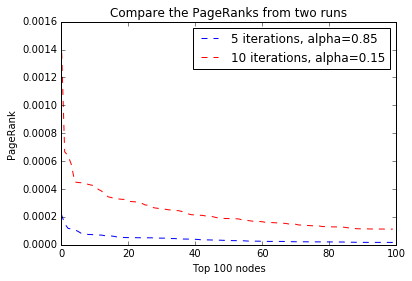

In [47]:
line1, = plt.plot(pd1[['pageRank']], 'b--', linewidth=1)
line2, = plt.plot(pd2[['pageRank']], 'r--', linewidth=1)
plt.legend((line1, line2), ('5 iterations, alpha=0.85', '10 iterations, alpha=0.15'))
plt.ylabel("PageRank")
plt.xlabel("Top 100 nodes")
plt.title("Compare the PageRanks from two runs")

plt.show()

The ranks of page have changed between the two runs.  From the blue graph (5 iterations, alpha=0.85) we can see that the PageRanks of the top 100 nodes are much lower than that in the red graph (10 iterations, alpha=0.15).  This makes sense because the blue graph has a much higher teleporting factor and thus the PageRanks are more evenly distributed, whereas in the red graph, the teleporting factor is much lower, and so the PageRanks concentrate much among those top 100 nodes.

## HW 9.4: Topic-specific PageRank implementation using MRJob

Modify your PageRank implementation to produce a topic specific PageRank implementation,
as described in:  

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.
This caveat lies in footnote 3 on page 3:

	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.

and must be adhered to for convergence to be guaranteed.

Run topic specific PageRank on the following randomly generated network of 100 nodes:

`s3://ucb-mids-mls-networks/randNet.txt (also available on Dropbox)`

which are organized into ten topics, as described in the file:

`s3://ucb-mids-mls-networks/randNet_topics.txt  (also available on Dropbox)`

Since there are 10 topics, your result should be 11 PageRank vectors
(one for the vanilla PageRank implementation in 9.1, and one for each topic
with the topic specific implementation). Print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result. 
Assume a teleportation factor of 0.15 in all your analyses.

One final and important comment here:  please consider the 
requirements for irreducibility with topic-specific PageRank.
In particular, the literature ensures irreducibility by requiring that
nodes not reachable from in-topic nodes be removed from the network.

This is not a small task, especially as it it must be performed
separately for each of the (10) topics.

So, instead of using this method for irreducibility, 
please comment on why the literature's method is difficult to implement,
and what what extra computation it will require.


Then for your code, please use the alternative, 
non-uniform damping vector:
```
vji = beta*(1/|Tj|); if node i lies in topic Tj

vji = (1-beta)*(1/(N - |Tj|)); if node i lies outside of topic Tj

for beta in (0,1) close to 1. 
```  

With this approach, you will not have to delete any nodes.
If beta > 0.5, PageRank is topic-sensitive, 
and if beta < 0.5, the PageRank is anti-topic-sensitive. 
For any value of beta irreducibility should hold,
so please try beta=0.99, and perhaps some other values locally,
on the smaller networks.

### Program to compute the damping vectors locally

In [125]:
%%writefile ComputeDampingVector.py
from __future__ import division
from collections import Counter
import json

import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--beta", type=float, default=0.99)
parser.add_argument("--topicTotal", type=int, default=10)
parser.add_argument("--jobPrefix", type=str, default="", help="Prefix string added to the front of any locally written file")
args = parser.parse_args()

# Read the topic of each node
nodeTopics = {}
topicSizes = Counter()
N = 0

with open("randNet_topics.txt", 'r') as f:
    for line in f:
        fields = line.strip().split('\t')
        node = int(fields[0])
        topic = int(fields[1])
        
        nodeTopics[node] = topic
        topicSizes[topic] += 1
        N += 1

dampingVectors = {}

# For each topic, calculate its damping vector
for topic in topicSizes.keys():
    topicSize = topicSizes[topic]
    vector = {}

    # Find out the v_ji for each node
    for node, nodeTopic in nodeTopics.items():    
        if nodeTopic == topic:
            #vji = beta*(1/|Tj|); if node i lies in topic Tj
            v = args.beta / topicSize
        else:
            #vji = (1-beta)*(1/(N - |Tj|)); if node i lies outside of topic Tj
            v = (1-args.beta) * (1/(N - topicSize))
            
        vector[node] = v
    
    dampingVectors[topic] = vector

for topic, vector in dampingVectors.items():    
    with open(args.jobPrefix + "vectors-topic-%s.txt" % str(topic), 'w') as f:
        f.write(json.dumps(vector))
        

Overwriting ComputeDampingVector.py


#### Compute the damping vectors for all topics

In [126]:
!python ComputeDampingVector.py \
--jobPrefix "hw94_" 

### Initialize the graph

In [127]:
!python Driver_Hw91.py -r inline \
--inputFile randNet.txt \
--jobPrefix "hw94_" \
--initGraphAndSizeOnly


Init Graph Structure  (0.00s from start)
No handlers could be found for logger "mrjob.sim"
Find Graph Size  (0.06s from start)
Number of nodes = 100  (0.09s from start)

Done initializing graph and get size.

Total time: 0.094s


#### Run it without topic-sensitive PageRank

In [137]:
!python Driver_Hw91.py -r inline \
--inputFile randNet.txt \
--jobPrefix "hw94_" \
--resultCount 10 \
--iteration 20 \
--quiet \
--resultFile hw94_normal-result.txt \
--skipInitGraphAndSize \


In [138]:
!ls -l hw94_normal-result.txt

-rw-r--r--  1 patrickng  staff  257 Mar 17 17:00 hw94_normal-result.txt


#### Run topic-sensitive PageRank over the 10 topics

In [132]:
!for i in {1..10}; do \
python Driver_Hw91.py -r inline \
--inputFile randNet.txt \
--jobPrefix "hw94_" \
--resultCount 10 \
--iteration 20 \
--quiet \
--dampingVectorFile hw94_vectors-topic-$i.txt \
--resultFile hw94_topic-$i-result.txt \
--skipInitGraphAndSize \
;done


In [133]:
!ls -l hw94_topic-*-result.txt

-rw-r--r--  1 patrickng  staff  257 Mar 17 16:54 hw94_topic-1-result.txt
-rw-r--r--  1 patrickng  staff  253 Mar 17 16:54 hw94_topic-10-result.txt
-rw-r--r--  1 patrickng  staff  258 Mar 17 16:54 hw94_topic-2-result.txt
-rw-r--r--  1 patrickng  staff  253 Mar 17 16:54 hw94_topic-3-result.txt
-rw-r--r--  1 patrickng  staff  256 Mar 17 16:54 hw94_topic-4-result.txt
-rw-r--r--  1 patrickng  staff  255 Mar 17 16:54 hw94_topic-5-result.txt
-rw-r--r--  1 patrickng  staff  252 Mar 17 16:54 hw94_topic-6-result.txt
-rw-r--r--  1 patrickng  staff  257 Mar 17 16:54 hw94_topic-7-result.txt
-rw-r--r--  1 patrickng  staff  255 Mar 17 16:54 hw94_topic-8-result.txt
-rw-r--r--  1 patrickng  staff  256 Mar 17 16:54 hw94_topic-9-result.txt


In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

allData = []
data = pd.read_csv('hw94_normal-result.txt', delimiter = '\t', header=None, names=['Normal', 'Score'])
allData.append(data[[0]])

# Read the topic of each node
nodeTopics = {}

with open("randNet_topics.txt", 'r') as f:
    for line in f:
        fields = line.strip().split('\t')
        node = int(fields[0])
        topic = int(fields[1])
        nodeTopics[node] = topic

for topic in range(1,11):
    data = pd.read_csv('hw94_topic-%d-result.txt' % topic, delimiter = '\t', header=None, names=['Topic %d' % topic, 'Score'])
    allData.append(data[[0]])

combined = pd.concat(allData, axis = 1)
combined = combined.applymap(lambda x: str(x) + " (%d)" % nodeTopics[x])

print
print "The number in the bracket is the topic of that node."
combined



The number in the bracket is the topic of that node.


,Normal,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,15 (3),32 (1),58 (2),15 (3),63 (4),99 (5),13 (6),85 (7),100 (8),94 (9),74 (10)
1,74 (10),77 (1),71 (2),70 (3),83 (4),90 (5),56 (6),25 (7),61 (8),14 (9),17 (10)
2,63 (4),52 (1),9 (2),86 (3),65 (4),88 (5),37 (6),28 (7),39 (8),42 (9),49 (10)
3,100 (8),92 (1),73 (2),91 (3),78 (4),51 (5),11 (6),53 (7),8 (8),21 (9),95 (10)
4,85 (7),10 (1),12 (2),66 (3),41 (4),45 (5),69 (6),35 (7),62 (8),57 (9),7 (10)
5,9 (2),27 (1),59 (2),2 (3),84 (4),5 (5),23 (6),97 (7),87 (8),96 (9),43 (10)
6,58 (2),85 (7),75 (2),31 (3),79 (4),34 (5),15 (3),47 (7),6 (8),24 (9),68 (10)
7,71 (2),98 (1),82 (2),40 (3),38 (4),4 (5),85 (7),55 (7),54 (8),63 (4),48 (10)
8,61 (8),46 (1),52 (1),20 (3),15 (3),80 (5),52 (1),30 (7),18 (8),61 (8),1 (10)
9,52 (1),74 (10),17 (10),74 (10),72 (4),100 (8),74 (10),50 (7),9 (2),74 (10),3 (10)


#### Comment

The literature ensures irreducibility by requiring that nodes not reachable from in-topic nodes be removed from the network.  It is very difficult because it means for each topic, for each zero node, we need to find out whether it is reacheable from at least one of the in-topic nodes.  Each one of this check requires at least one graph search.  

Now for the 11 result using the alternative way to generate non-uniform vectors, the above above shows that the ranking is quite different between those 11 results.  Inside each cell, the number in the bracket is the topic of that node.  We can see that with beta = 0.99, topics which belong to the corresponding topic really rank high.